In [ ]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/221001/winequality-red.csv")

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
x = x.values
y = y.values

In [ ]:
list(set(y))

[3, 4, 5, 6, 7, 8]

In [ ]:
y_list = list(y)

In [ ]:
y_bar = []
for num in range(3, 9):
  counts = y_list.count(num)
  y_bar.append(counts)
  print(f"quality {num} : {counts}")

quality 3 : 10
quality 4 : 53
quality 5 : 681
quality 6 : 638
quality 7 : 199
quality 8 : 18


<BarContainer object of 6 artists>

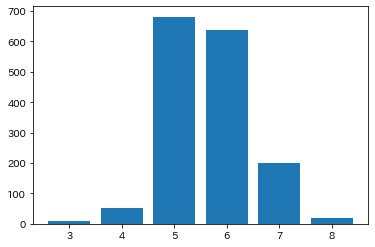

In [ ]:
left = np.array([3, 4, 5, 6, 7, 8])
height = y_bar
plt.bar(left, height)

In [ ]:
# 3,4→0  5,6→1  7,8→2
y_dict_values = [0, 0, 1, 1, 2, 2]
y_dict_keys = list(set(y))
y_dict = dict(zip(y_dict_keys,y_dict_values))

In [ ]:
y_dict

{3: 0, 4: 0, 5: 1, 6: 1, 7: 2, 8: 2}

In [ ]:
y_labels = np.array([])
for num in range(len(y)):
  work = y[num]
  y_label = y_dict[work]
  y_labels = np.append(y_labels, y_label)

In [ ]:
set(y_labels)

{0.0, 1.0, 2.0}

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_labels, test_size=0.2)

In [ ]:
# パラメータ

# 入力次元数
n_input = x_train.shape[1]

# 出力次元数
n_output = len(list(set(y_train)))

print(f"n_input : {n_input} n_output : {n_output}")

n_input : 11 n_output : 3


In [ ]:
# モデル定義

class Net(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()
    self.l1 = nn.Linear(n_input, 5)
    self.l2 = nn.Linear(5, n_output)
    self.relu = nn.ReLU(inplace=True)

    # 値の初期化
    self.l1.weight.data.fill_(1.0)
    self.l1.bias.data.fill_(1.0)
  
  def forward(self, x):
    x1 = self.relu(self.l1(x))
    x2 = self.l2(x1)
    return x2

In [ ]:
# 値のtensor化
# ラベルは整数なので、long型
inputs_train = torch.tensor(x_train).float()
labels_train = torch.tensor(y_train).long()
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [ ]:
# 繰り返し計算

# 学習率
lr = 0.0003

# インスタンス生成
# 初期化
net = Net(n_input, n_output)

# 損失関数 : 交差エントロピー関数
# 線形では、MSELossを使っていた
criterion = nn.CrossEntropyLoss()

# 最適化関数 : 勾配降下法
optimizer = optim.SGD(net.parameters(), lr = lr)

# 繰り返し回数
num_epochs = 20000

# 評価結果記録用
history = np.zeros((0, 5))

In [ ]:
# 処理

for epoch in range(num_epochs):
  
  #-------------学習----------------
  
  # 勾配の初期化
  optimizer.zero_grad()

  # 予測計算
  outputs_train = net(inputs_train)

  # 損失計算
  loss = criterion(outputs_train, labels_train)

  # 勾配計算
  loss.backward()

  # パラメータ修正
  optimizer.step()

  # 予測ラベル算出
  # スコアが一番高いもの
  predicated = torch.max(outputs_train, 1)[1]

  # 損失と精度の計算
  # 予測と実際の値が合っているものの合計をラベルの大きさで割れば、予測精度がわかる
  train_loss = loss.item()
  train_acc = (predicated == labels_train).sum()/len(labels_train)

  #-------------予測----------------

  # 予測計算
  outputs_test = net(inputs_test)

  # 損失計算
  loss_test = criterion(outputs_test, labels_test)

  # 予測ラベル算出
  predicated_test = torch.max(outputs_test, 1)[1]

  # 損失と精度の計算
  val_loss = loss_test.item()
  val_acc = (predicated_test == labels_test).sum()/len(labels_test)



  # 記録
  if((epoch) % 100 == 0):
    print(f"Epoch [{epoch}/{num_epochs}], loss:{train_loss:.5f} acc:{train_acc:.5f} val_loss: {val_loss:.5f} val_acc: {val_acc:.5f}")
    item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))



Epoch [0/20000], loss:38.72180 acc:0.03909 val_loss: 16.97965 val_acc: 0.04062
Epoch [100/20000], loss:0.57561 acc:0.82643 val_loss: 0.59115 val_acc: 0.81875
Epoch [200/20000], loss:0.57443 acc:0.82643 val_loss: 0.59812 val_acc: 0.81875
Epoch [300/20000], loss:0.57360 acc:0.82643 val_loss: 0.60424 val_acc: 0.81875
Epoch [400/20000], loss:0.57322 acc:0.82643 val_loss: 0.60977 val_acc: 0.81875
Epoch [500/20000], loss:0.57311 acc:0.82643 val_loss: 0.61457 val_acc: 0.81875
Epoch [600/20000], loss:0.57315 acc:0.82643 val_loss: 0.61860 val_acc: 0.81875
Epoch [700/20000], loss:0.57325 acc:0.82643 val_loss: 0.62188 val_acc: 0.81875
Epoch [800/20000], loss:0.57335 acc:0.82643 val_loss: 0.62449 val_acc: 0.81875
Epoch [900/20000], loss:0.57344 acc:0.82643 val_loss: 0.62652 val_acc: 0.81875
Epoch [1000/20000], loss:0.57350 acc:0.82643 val_loss: 0.62808 val_acc: 0.81875
Epoch [1100/20000], loss:0.57352 acc:0.82643 val_loss: 0.62926 val_acc: 0.81875
Epoch [1200/20000], loss:0.57352 acc:0.82643 val_l

In [ ]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 16.97965 精度: 0.04062
最終状態: 損失: 0.61354 精度: 0.81875


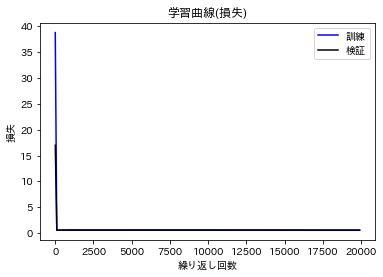

In [ ]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

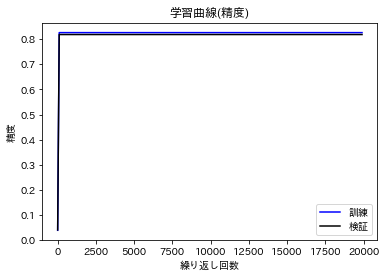

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()